# Numerical Integration on SO(3)
One challenge of using proper representations of orientation such as rotation matrices or quaternions is properly performing numerical integration.
Many methods have been used for this, here I compare two using fourth order Runge-Kutta numerical integration.


In [1]:
import LinearAlgebra
LA = LinearAlgebra
using Plots
using LaTeXStrings
using ForwardDiff


### Super brief Lie group stuff
* Rotation matrices are members of the Lie group $\mathsf{SO(3)} = \{R \in \mathbb{R}^{3\times3} | R^T R = I, \mathrm{det}[R] = 1\}$. That is, the set of orthogonal $3\times3$ matrices with determinant 1.
* Every Lie Group has an associated Lie algebra which is the tangent space at the identity element. Derivatives or perturbations of members of a Lie group occur in the Lie algebra. For rotation matrices, the identity element is the identity matrix, $I$, and the Lie algebra is $\mathfrak{so}(3)$, the set of skew-symmetric matrices. The Lie algebra is isomorphic to $\mathbb{R}^3$, and the mapping is $(\cdot)^\wedge : \mathbb{R}^3 \to \mathfrak{so}(3)$. Note that this mapping corresponds to that of the cross operator $[\cdot]_\times$. 
* The exponential map $\mathrm{exp}: \mathfrak{so}(3) \to \mathsf{SO(3)}$ can be used to find the effect of perturbations on a rotation matrix.
* The Lie bracket is a binary operation on Lie algebras, denoted $[\cdot, \cdot]$. For matrix Lie algebras, such as $\mathfrak{so}(3)$, the Lie bracket is $[A, B] = AB - BA$ for $A, B \in \mathfrak{so}(3)$

In [4]:
lie_eps = 1e-8 # used to check functions for places with numerical problems

function crossMat(w)
    """
    computes the skew-symmetric matrix from a 3-vector
    """
    wx = [0.0 -w[3] w[2]; w[3] 0.0 -w[1]; -w[2] w[1] 0.0]
    return wx
end

function hat(tau)
    """
    Computes the hat map, which maps from R^3 -> so(3)
    """
    return crossMat(tau)
end 

function vee(taux)
    """
    Computes the vee map, which maps from so(3) -> R^3
    """
    tau = [taux[3,2], taux[1, 3], taux[2,1]]
    return tau
end 

function expSO3(wx)
    """
    Computes the exponential map, which maps from so(3) -> SO(3)
    see Jackson's Transformations for Dummies for an explanation of the math
    """
    # find the angle/axis representation
    w = vee(wx)
    
    # ||w||
    theta = LA.norm(w) # Note: sqrt(w'*w) failed for autodiff of vectors with magnitude 0 
    if (theta > 0.0 + lie_eps)
        # use large-angle (Rodriguez formula)
        R = LA.I + wx*(sin(theta)/theta) + wx*wx*((1-cos(theta))/theta^2)
    else
        # use small-angle (Taylor expansion)
        R = LA.I + wx*(1 - theta^2/6 + theta^4/120 ) + wx*wx*(1/2 - theta^2/24 + theta^4/720)
    end
    return R
end

function logSO3(R)
    """
    Computes the logarithmic map, which maps from SO(3) -> so(3)
    """
    
    #### TODO ####
    temp = (LA.tr(R) - 1.0)/2.0
    if temp > 1.0
        temp = 1.0
    elseif temp < 0.0
        temp = 0.0
    end
    
    theta = acos(temp)
    
    if (theta > 0+ lie_eps && theta < pi/2 - lie_eps)
        # use large-angle
        logR = (theta/(2*sin(theta)))*(R-R')
    else
        # use small angle (Taylor Series)
        logR = (1.0/2.0)*(1+(1/6)*theta^2 + (7/360)*theta^4)*(R-R')
    end
    
    return logR
end

function lieBrack(A,B)
    """
    Computes the Lie bracket for matrix lie algebras, such as so(3)
    """
    return A*B - B*A
end
    

function rot2euler(R)
    """
    Convert a rotation matrix to euler angles for plotting
    """
    if abs(R[3,1]) <= (1.0 - lie_eps) # R31 != 1.0
        theta = -asin(R[3,1])
        ctheta = cos(theta)
        psi = atan(R[3,2]/ctheta, R[3,3]/ctheta)
        phi = atan(R[2,1]/ctheta, R[1,1]/ctheta)
    else
        phi = 0
        if R[3,1] < 0
            theta = pi/2
            psi = phi + atan(R[1,2], R[1,3])
        else
            theta = -pi/2
            psi = -phi + atan(-R[1,2], -R[1,3])
        end
    end
    
    return phi, theta, psi # roll, pitch, yaw
end    
   
function test1()
    w = [1., 2., 3.]
    
    wx = hat(w)
    println("wx = ", wx + wx')
    
    Rw = expSO3(wx)
    
    println("Rw = ", Rw - exp(wx))
end


test1()

wx = [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
Rw = [0.0 0.0 -2.7755575615628914e-17; 2.7755575615628914e-17 -1.1102230246251565e-16 2.220446049250313e-16; 0.0 0.0 -5.551115123125783e-17]


### Dynamics
We will consider the constant angular rate attitude dynamics of a 3 dimensional rigid body, given by
\begin{align}
\dot{R} &= f(R,\omega) = -\omega^\wedge R
\end{align}
where $\omega \in \mathbb{R}^3$ is the angular rate of the body, represented in the body frame, and $R \in \mathsf{SO(3)}$ is a rotation matrix from an inertial frame to the body frame. For simplicity, we assume that $\omega = [1, 1, 1]^T$.
Using inertial dynamics was chosen to make the dynamics right-invariant so the integration techniques described below can be applied.

In [6]:
function attDynamics(R, omega)
    Rdot = -hat(omega)*R
    return Rdot
end    
identity(nothing)

## Numerical Integration
The integration of $R$ must be done properly in order for the solution to remain on the manifold of $\mathsf{SO(3)}$. 
Assuming constant $\omega$ the solution to $\dot{R} = -\omega^\wedge R$ is 
$$
R(t) = \mathrm{exp}(-\omega^\wedge t)R(0).
$$ 

If instead, we let $\omega$ vary over time, we get the euler approximation,
$$
R_{k+1} \approx \mathrm{exp}(-\omega^\wedge \mathrm{T_s}) R_k 
$$

### Naive RK4
One would naively think (I did) that to extend this to fourth order Runge-Kutta one would simply do the following:
\begin{align}
F_1 &= -\omega^\wedge R_k\\
F_2 &= -\omega^\wedge \exp(F_1 \frac{T_s}{2}) R_k \\
F_3 &= -\omega^\wedge \exp(F_2 \frac{T_s}{2}) R_k \\
F_4 &= -\omega^\wedge \exp(F_3 T_s) R_k
\end{align}

And then sum the result:
$$
R_{k+1} = R_k + \frac{Ts}{6} (F_1 + 2F_2 + 2F_3 + F_4)
$$

This seems like it would work, because $F_1 \dots F_4$ are members of the tangent space where addition is defined. However it is incorrect as the intermediate terms $F_1 \dots F_4$ reside in different tangent spaces and thus should not be added together.

In [19]:
function naiveRK4(R_k, omega; Ts=0.01)
    """
    Propagate the rotation dynamics by one timestep using RK4 integration
    """
    
    F1 = -hat(omega) * R_k
    F2 = -hat(omega) * expSO3(F1*Ts/2) * R_k
    F3 = -hat(omega) * expSO3(F2*Ts/2) * R_k
    F4 = -hat(omega) * expSO3(F3*Ts) * R_k
    
    R_kp1 = R_k + (Ts/6)*(F1 + 2*F2 + 2*F3 + F4)
    
    return R_kp1
end

naiveRK4 (generic function with 1 method)

Because of the error incrued by this method, the rotation matrix will slowly diverge from being orthogonal, which means that it will no longer be in $\mathsf{SO(3)}$ and it is no longer a valid rotation. To correct for this, a typical practice is to orthonormalize the new rotation matrix ($R_{k+1}$) on each timestep.

I tried three different methods of normalizing a rotation matrix. To compare between the methods, I used two different metrics, $\mathrm{tr}(R^TR) - 3$, which allows me to see how far off from orthogonal the rotation matrix is, and $\|\log(R_n^T R)^\wedge\|$, where $R_n$ is the normalization of $R$. This method allowed me to see "how close" the rotations were to each other. I also used the Euler-angle representation of the rotation matrix to examine the effect of the different normalizations.

1. Using the singular value decomposition:
\begin{align}
U, \Sigma, V^T = \mathrm{SVD}(R)\\
R_n = U V^T
\end{align}
```
U, S, Vt = LA.svd(R_kp1)
R_kp1 = U*Vt
```
This did produce an orthogonal matrix, but it caused large jumps (up to 1.5) in $\|\log(R_n^T R)^\wedge\|$.

2. Using the QR decomposition
\begin{align}
Q, U = \mathrm{QR}(R)\\
R_n = Q
\end{align}
```       
Q, _ = LA.qr(R_kp1)
R_kp1 = Q
```
This also produced an orthogonal matrix, and $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$, however the euler angles produced by the rotation were hard to interpret and had additional discontinuities.

3. Using the Gram-Schmidt orthogonalization on the columns of R. This isn't implemented in a Julia library, so I wrote my own super simple implementation that will only work for $3\times3$ matrices.
\begin{align}
R_n = \mathrm{GramSchmidt}(R)
\end{align}
```
R_kp1 = gramSchmidt(R_kp1)
```
This produced the best results, with the error $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$ and the euler angles looking the same as they did without orthogonalization, having discontinuities only at $\pm \pi$. 

In [8]:

function gramSchmidt(R)
    """
    Orthonormalize a 3x3 matrix
    """
    p1 = R[:,1]
    p2 = R[:,2]
    p3 = R[:,3]

    q1 = p1/LA.norm(p1)
    e2 = p2 - (p2'*q1)*q1
    q2 = e2/LA.norm(e2)
    e3 = p3 - (p3'*q1)*q1 - (p3'*q2)*q2
    q3 = e3/LA.norm(e3)
    
    return hcat(q1, q2, q3)
end

gramSchmidt (generic function with 1 method)

### Optimized RK4 for Lie Algebras
I don't have much information on this at the moment, but this is supposed to be the correct way to perform RK4 on a Lie group/Lie algebra.
\begin{align}
F_1 &= -T_s\omega^\wedge R_k\\
F_2 &= -T_s\omega^\wedge \exp(\frac{1}{2} F_1) R_k \\
F_3 &= -T_s\omega^\wedge \exp(\frac{1}{2} F_2 - \frac{1}{8} [F_1, F_2]) R_k \\
F_4 &= -T_s\omega^\wedge \exp(F_3) R_k
\end{align}

$$
R_{k+1} = \exp(\frac{1}{6} (F_1 + 2F_2 + 2F_3 + F_4 - \frac{1}{2} [F_1, F_4]))R_k
$$

In [18]:
function optimRK4(R_k, omega; Ts=0.01)
    """
    Propagate the rotation dynamics by one timestep using RK4 integration
    """
    
    F1 = -Ts*hat(omega) * R_k
    F2 = -Ts*hat(omega) * expSO3(F1/2.0) * R_k
    F3 = -Ts*hat(omega) * expSO3(F2/2.0 - lieBrack(F1, F2)) * R_k
    F4 = -Ts*hat(omega) * expSO3(F3) * R_k
    
    R_kp1 = expSO3((1/6)*(F1 + 2*F2 + 2*F3 + F4 - (1/2)*lieBrack(F1,F4)))*R_k
    
    return R_kp1
end

optimRK4 (generic function with 1 method)

In [21]:
function plotR(R_vec, tf; Rd_vec=nothing)
    # convert R_vec to euler angles
    N = size(R_vec)[3]
    tvec = range(0, stop=tf, length=N)
    euler_vec = zeros(3, N)
    for k = 1:N
        phi, theta, psi = rot2euler(R_vec[:,:,k])
        euler_vec[:,k] = [phi, theta, psi]
    end
    
    euler_plot = plot(tvec, euler_vec[:,:]', label=[L"\phi" L"\theta" L"\psi"], legend=false, linewidth=1.5, xlabel="Time (s)", title="Euler Angles")

    if !isnothing(Rd_vec)
        N = size(Rd_vec)[3]
        tvec = range(0, stop=tf, length=N)
        eulerd_vec = zeros(3,N)
        for k = 1:N
            phi, theta, psi = rot2euler(Rd_vec[:,:,k])
            eulerd_vec[:,k] = [phi, theta, psi]
        end
        plot!(tvec, eulerd_vec[:,:]', label=[L"\phi_d" L"\theta_d" L"\psi_d"], linestyle=:dash, color=[1 2 3])
    end
    
    return euler_plot
end

function plotRerr(R_vec, Rd_vec, tf)  
    N = size(R_vec)[3]
    tvec = range(0, stop=tf, length=N)
    
    Rerr = zeros(N)
    for k = 1:N
        Rerr[k] = LA.norm(R_vec[:,:,k] .- Rd_vec[:,:,k])
    end
    plot(tvec, Rerr, linewidth=1.5, title=L"\|R - R_d \|", xlabel="Time (s)", legend=false)
end
identity(nothing)

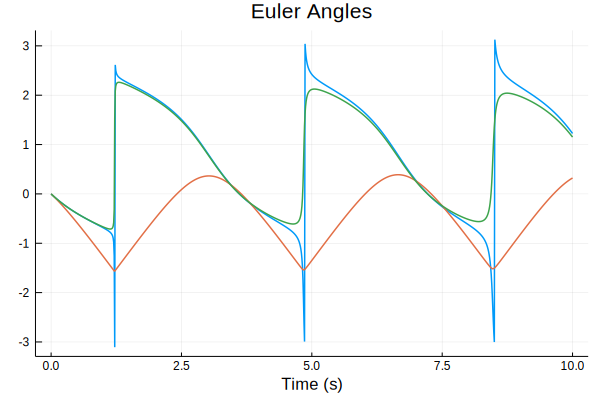

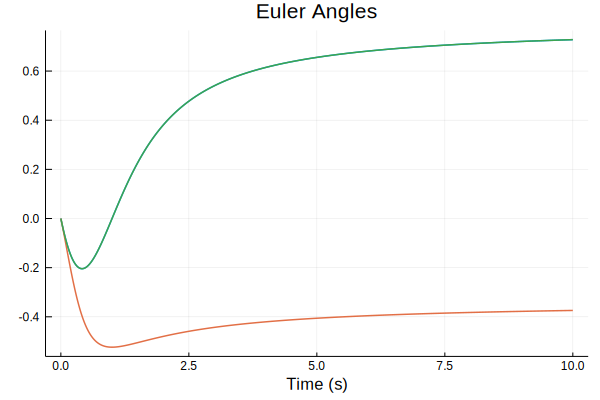

In [25]:
function runDynamics(R0, omega, propagFn; Ts=0.01, tf=10, orthog=false)
    """
    Propagate the dynamics using propagFn 
    and save R
    Assumes constant omega
    """
    
    N = Int(tf/Ts)
    
    R_vec = zeros(3,3,N+1)
    R_no_ortho = zeros(3,3,N+1)
    u_vec = zeros(3,1,N)
    
    R_vec[:,:,1] = R0
    R_no_ortho[:,:,1] = R0
    
    R_k = R0
       
    for k in range(1, length=N)
        R_kp1 = propagFn(R_k, omega)
        
        # orthogonalize R
        if orthog
            R_no_ortho[:,:,k+1] = R_kp1
            R_kp1 = gramSchmidt(R_kp1)
        end
                
        R_vec[:,:,k+1] = R_kp1
        R_k = R_kp1
    end
    
    return R_vec
end

function runIntegrators()
      
    R0 = Matrix{Float32}(LA.I, 3, 3)
    omega = 1.0*ones(3)
    
    R_vec_naive = runDynamics(R0, omega, naiveRK4, orthog=true)
    R_vec_optim = runDynamics(R0, omega, optimRK4)
    
    return R_vec_naive, R_vec_optim
end

R_vec_naive, R_vec_optim = runIntegrators()

display(plotR(R_vec_naive, 10))
display(plotR(R_vec_optim, 10))

identity(nothing)